# Actor Critic

In this notebook, we train AC with OpenAI Gym's CartPole-v1 environment.

## 1. Import the Necessary Packages

In [2]:
import os
import gym
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

ENV_NAME = "CartPole-v1"
#LOAD_MODEL 
SAVE_PATH = './save_model/'
RENDER = False
GAMMA = 0.99
HIDDEN_SIZE = 64
ACTOR_LR =1e-4
CRITIC_LR =1e-3
ENT_COEF = 0.1
MAX_ITER_NUM =1000
LOG_INTERVAL = 10
GOAL_SCORE =475
LOGDIR ='./logs'

SEED= 100


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make(ENV_NAME)
env.seed(SEED)
torch.manual_seed(SEED)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


## 2. Define Model Network

In [4]:
import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_size, action_size, rnd_seed):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, action_size)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        policies = torch.softmax(self.fc3(x), dim=1)
        return policies
        #return torch.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self,state_size, args):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

## 3. Train agent w/ Actor Critic (Single Step)

<img src='AC.png' width=800px>

In [5]:
# update actor, critic parameter every step

def train_model(actor,critic,actor_optimizer, critic_optimizer, transition, policies):
    state, action, reward, next_state, mask = transition
    
    #update critic
    criterion = torch.nn.MSELoss()
    
    value = critic(torch.Tensor(state).to(device)).squeeze(1)
    next_value = critic(torch.Tensor(next_state).to(device)).squeeze(1)
    target = reward + mask * GAMMA * next_value
    
    critic_loss = criterion(value, target.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    #update actor
    categorical = Categorical(policies)
    log_policy = categorical.log_prob(torch.Tensor([action]).to(device))
    
    entropy = categorical.entropy()
    
    advantage = target - value
    
    #actor_loss = -log_policy * advantage.item()
    actor_loss = -log_policy * advantage.item() + ENT_COEF*entropy
    
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

In [6]:
def get_action(policies):
    categorical = Categorical(policies)
    action = categorical.sample()
    action = action.data.numpy()[0]
    return action

In [11]:
actor = Actor(state_size, action_size, SEED)
critic = Critic(state_size, SEED)

def Agent():
        
    actor_optimizer = optim.Adam(actor.parameters(), lr = ACTOR_LR)
    critic_optimizer = optim.Adam(critic.parameters(), lr = CRITIC_LR)
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    actor.to(device)
    critic.to(device)

    
    for episode in range(MAX_ITER_NUM):
        done = False
        score = 0
        
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        
        while not done:
            if RENDER:
                env.render()
                
            policies = actor(torch.Tensor(state).to(device))
            action = get_action(policies.to(device))
            
            next_state, reward, done, _ = env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size])
            mask = 0 if done else 1
            
            transition = [state,action,reward, next_state, mask]
            
            train_model(actor, critic, actor_optimizer, critic_optimizer, transition, policies)
            state = next_state
            score += reward

        scores_deque.append(score)
        
        if episode >= 100:
            moving_avg_score = np.mean(scores_deque)
            scores.append(moving_avg_score)

            if episode % LOG_INTERVAL == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, moving_avg_score, score))
            
                if moving_avg_score > GOAL_SCORE:
                    print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, moving_avg_score, score))
                    if not os.path.isdir(SAVE_PATH):
                        os.mkdir(SAVE_PATH)
                    torch.save(actor.state_dict(),SAVE_PATH+'checkpoint_actor.pth')
                    torch.save(critic.state_dict(),SAVE_PATH+'checkpoint_critic.pth')

                    return scores
            
    return scores

Episode 100	Average Score: 62.37	Score: 165.00
Episode 110	Average Score: 88.10	Score: 248.00
Episode 120	Average Score: 100.11	Score: 42.00
Episode 130	Average Score: 108.38	Score: 144.00
Episode 140	Average Score: 123.48	Score: 267.00
Episode 150	Average Score: 138.07	Score: 194.00
Episode 160	Average Score: 154.12	Score: 209.00
Episode 170	Average Score: 168.38	Score: 140.00
Episode 180	Average Score: 201.43	Score: 397.00
Episode 190	Average Score: 236.14	Score: 500.00
Episode 200	Average Score: 264.70	Score: 500.00
Episode 210	Average Score: 287.19	Score: 500.00
Episode 220	Average Score: 321.67	Score: 366.00
Episode 230	Average Score: 351.40	Score: 500.00
Episode 240	Average Score: 363.44	Score: 168.00
Episode 250	Average Score: 379.23	Score: 500.00
Episode 260	Average Score: 406.14	Score: 500.00
Episode 270	Average Score: 436.56	Score: 500.00
Episode 280	Average Score: 446.23	Score: 500.00
Episode 290	Average Score: 446.60	Score: 500.00
Episode 300	Average Score: 448.76	Score: 34

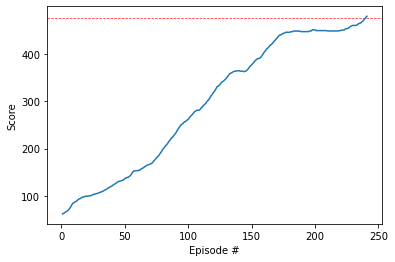

In [12]:
scores = Agent()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y=GOAL_SCORE, xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Watch a smart agent

In [13]:
actor.load_state_dict(torch.load(SAVE_PATH+'checkpoint_actor.pth'))
critic.load_state_dict(torch.load(SAVE_PATH+'checkpoint_critic.pth'))

state = env.reset()
for t in range(1000):
    policies = actor(torch.Tensor(state).unsqueeze(0)).to(device)
    action = get_action(policies.cpu())
    #action = get_action(torch.Tensor(state).unsqueeze(1))
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

print(t)
env.close()    

In [14]:
env.close()